# CNN을 이용하여 cifar10 데이터셋 분류하기

keyword: CNN, convolution, pooling, vgg16, resnet50, pretrained model, transfer learning, fine tunning

- key word에 대해서 이해하고, 숙지할것

- 1. mnist dataset에서 쌓은 경험으로, 자유롭게 모델링 할것
- 2. vggnetwork를 불러와서 (img size 244,244로 해야함) 새로운 layer를 추가하고, 기존의 모델은 freeze해서 추가학습을 진행할것

- 3. 본인의 방법과 vggnet의 결과를 비교하며, 최대한 성능을 비슷하게 여러방법을 사용해서 자신이 모델링한것들을 수정해볼것.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [3]:
transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=12)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=12)

In [4]:

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


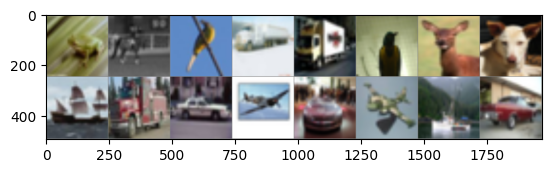

frog  horse bird  truck


In [6]:
# 실행할수록 출력되는 이미지 달라지니, 여러번 실행해서 확인해보자
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# your code here

In [7]:
# 내 모델 정의
import torch.nn.functional as F
class NeuralNetDeep(nn.Module):  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 추가층
        self.pool = nn.MaxPool2d(2, 2)  # 풀링 추가
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) #추가층
        self.fc1 = nn.Linear(3 * 244 * 244, 512) 
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [31]:
# VGGNet 모델 불러오기
num_classes = 10
from torchvision import models as tv_models

class VGG16Model(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        base = tv_models.vgg16(pretrained=True)
        
        self.features = base.features          # Conv blocks
        self.avgpool = base.avgpool            # AdaptiveAvgPool2d((7,7))
        
        for param in self.features.parameters():
            param.requires_grad = False        # Feature extractor freeze

        # ✅ Custom classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),      # 25088 → 1024
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        

        x = torch.flatten(x, 1)                # (B, 512, 7, 7) → (B, 25088)
        x = self.classifier(x)
        return x

In [ ]:
# 새로운 분류기 레이어를 VGGNet 끝단에 추가


In [32]:
# 손실함수, optimizer 등등 정의

models = {
    #"Baseline": NeuralNet,
    #"Dropout": NeuralNetDropout,
    #"BatchNorm": NeuralNetBatchNorm,
    "Deep": NeuralNetDeep,
    "VGG16": VGG16Model
}

optimizers = {
    "SGD": lambda model: optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
    #"Adam": lambda model: optim.Adam(model.parameters(), lr=0.001)
}


criterion = nn.CrossEntropyLoss()  # 크로스 엔트로피 손실 함수


In [33]:
# 학습 (나의 모델, vgg 모델 둘다 학습할것)

num_epochs = 10

def train_model(model, optimizer, train_loader, criterion, num_epochs=10):
    model.to(device)
    train_losses = []
    train_accuracies = []
    print("Epochs: ", num_epochs)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")

    return train_losses, train_accuracies

def evaluate_model(model, test_loader, criterion):
    model.to(device)
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss = {avg_loss:.4f}, Test Accuracy = {accuracy:.2f}%")

    return avg_loss, accuracy

Using device: cuda

Training Deep with SGD


/home/peteryksong/.local/lib/python3.10/site-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Epochs:  10
Epoch 1: Loss = 2.1986, Accuracy = 20.68%
Epoch 2: Loss = 2.2161, Accuracy = 18.68%
Epoch 3: Loss = 2.2412, Accuracy = 16.35%
Epoch 4: Loss = 2.2301, Accuracy = 16.29%
Epoch 5: Loss = 2.2331, Accuracy = 15.82%
Epoch 6: Loss = 2.2223, Accuracy = 15.89%
Epoch 7: Loss = 2.1950, Accuracy = 17.12%
Epoch 8: Loss = 2.1847, Accuracy = 17.12%
Epoch 9: Loss = 2.1812, Accuracy = 17.10%
Epoch 10: Loss = 2.1750, Accuracy = 17.37%
Test Loss = 2.2044, Test Accuracy = 17.33%
Training Time: 605.01 seconds ⏳

Training VGG16 with SGD
Epochs:  10
Epoch 1: Loss = 0.7303, Accuracy = 75.30%
Epoch 2: Loss = 0.4779, Accuracy = 83.78%
Epoch 3: Loss = 0.3677, Accuracy = 87.47%
Epoch 4: Loss = 0.2844, Accuracy = 90.15%
Epoch 5: Loss = 0.2397, Accuracy = 91.67%
Epoch 6: Loss = 0.1962, Accuracy = 93.28%
Epoch 7: Loss = 0.1637, Accuracy = 94.48%
Epoch 8: Loss = 0.1446, Accuracy = 95.15%
Epoch 9: Loss = 0.1280, Accuracy = 95.68%
Epoch 10: Loss = 0.1139, Accuracy = 96.16%
Test Loss = 0.5448, Test Accuracy 

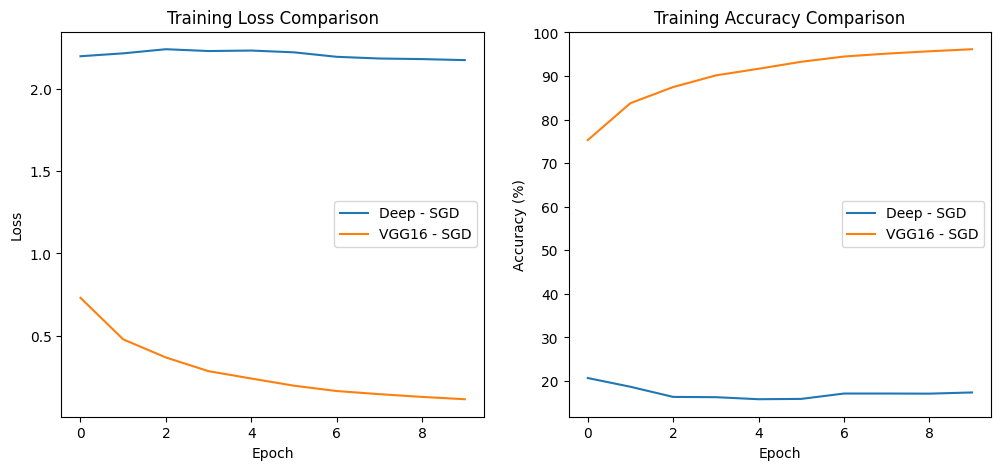

In [34]:
# 본인의 모델과 vggnet의 결과를 비교
# plot result
import gc
import time  # 시간 측정
import seaborn as sns  # 그래프 시각화

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Print the selected device

results = {}

# 모든 모델의 Loss & Accuracy를 하나의 그래프에 저장할 리스트
all_train_losses = {}
all_train_accuracies = {}

for model_name, model_class in models.items():
    for opt_name, opt_func in optimizers.items():
        print(f"\nTraining {model_name} with {opt_name}")

        # 기존 모델 및 메모리 완전 초기화
        if 'model_instance' in locals():
            del model_instance  # 모델 객체 삭제
            gc.collect()  # 가비지 컬렉션 실행

            if torch.cuda.is_available():  # GPU 사용 시만 실행
                torch.cuda.empty_cache()  # GPU 메모리 캐시 비우기
                torch.cuda.ipc_collect()
                torch.cuda.reset_max_memory_allocated()  # GPU 메모리 사용 기록 초기화

        # 새로운 모델 및 옵티마이저 생성
        model_instance = model_class()  # 새로운 모델 인스턴스 생성 (CPU)
        model_instance.to(device)  # 이후에 GPU로 이동
        optimizer = opt_func(model_instance)  # 새로운 Optimizer 설정

        # 학습 시간 측정 시작
        start_time = time.time()

        # 학습 실행
        train_losses, train_accuracies = train_model(model_instance, optimizer, trainloader, criterion, num_epochs)

        # 학습 종료 시간 기록
        end_time = time.time()
        training_time = end_time - start_time  # ⏳ 학습 소요 시간 계산

        # 평가 실행
        test_loss, test_accuracy = evaluate_model(model_instance, testloader, criterion)

        # 결과 저장
        results[(model_name, opt_name)] = {
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
            "training_time": training_time  # ⏳ 학습 시간 저장
        }

        # 그래프 데이터 저장 (Loss & Accuracy)
        label = f"{model_name} - {opt_name}"
        all_train_losses[label] = train_losses
        all_train_accuracies[label] = train_accuracies

        # 학습 시간 출력
        print(f"Training Time: {training_time:.2f} seconds ⏳")

# Loss & Accuracy 그래프 통합 출력
plt.figure(figsize=(12, 5))

# 🔹 Training Loss Plot
plt.subplot(1, 2, 1)
for label, losses in all_train_losses.items():
    plt.plot(losses, label=label)
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 🔹 Training Accuracy Plot
plt.subplot(1, 2, 2)
for label, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=label)
plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()



# 결과의 출력

Using device: cuda  
  
Training Deep with Adam  
Epochs:  10  
Epoch 1: Loss = 2.1208, Accuracy = 27.72%  
Epoch 2: Loss = 1.9448, Accuracy = 28.53%  
Epoch 3: Loss = 1.9390, Accuracy = 28.01%  
Epoch 4: Loss = 1.9246, Accuracy = 28.42%  
Epoch 5: Loss = 1.9062, Accuracy = 28.79%  
Epoch 6: Loss = 1.9103, Accuracy = 29.17%  
Epoch 7: Loss = 1.8874, Accuracy = 29.91%  
Epoch 8: Loss = 1.8725, Accuracy = 30.07%  
Epoch 9: Loss = 1.8748, Accuracy = 30.29%  
Epoch 10: Loss = 1.8649, Accuracy = 30.84%  
Test Loss = 1.9889, Test Accuracy = 24.10%  
Training Time: 1133.16 seconds ⏳  
  
Training VGG16 with Adam  
Epochs:  10  
Epoch 1: Loss = 2.3303, Accuracy = 10.05%  
Epoch 2: Loss = 2.3062, Accuracy = 9.78%  
Epoch 3: Loss = 2.3050, Accuracy = 10.02%  
Epoch 4: Loss = 2.3048, Accuracy = 9.98%  
Epoch 5: Loss = 2.3043, Accuracy = 9.88%  
Epoch 6: Loss = 2.3038, Accuracy = 9.82%  
...  
Epoch 9: Loss = 2.3034, Accuracy = 9.78%  
Epoch 10: Loss = 2.3031, Accuracy = 10.12%  
Test Loss = 2.3027, Test Accuracy = 10.00%  
Training Time: 7903.00 seconds ⏳  
  
우선 결과 분석. 
1. Epoch 가 적은가? (30~50까지 늘려볼것을 권장함. )  -->초기 경향 보는 것이니 10으로 하자. 
2. CNN 기본 모델의 학습율이 MNIST 대비해서 적은데,   
   1. 244x244 는 VGG 용임. 일반 CNN 으로 하려면 32x32로 해보라고 함. 
   2. Classfier의 변경. 기존에 단순 리니어였는데, 레이어와 풀링을 추가함. 
   3. freeze는 손대지 않음. 
   

In [23]:
import gc
gc.collect()
torch.cuda.empty_cache()

최종결과 

Using device: cuda  
 
Training Deep with SGD  
/home/peteryksong/.local/lib/python3.10/site-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.  
  warnings.warn(  
Epochs:  10  
Epoch 1: Loss = 2.1986, Accuracy = 20.68%  
Epoch 2: Loss = 2.2161, Accuracy = 18.68%  
Epoch 3: Loss = 2.2412, Accuracy = 16.35%  
Epoch 4: Loss = 2.2301, Accuracy = 16.29%  
Epoch 5: Loss = 2.2331, Accuracy = 15.82%  
Epoch 6: Loss = 2.2223, Accuracy = 15.89%  
Epoch 7: Loss = 2.1950, Accuracy = 17.12%  
Epoch 8: Loss = 2.1847, Accuracy = 17.12%  
Epoch 9: Loss = 2.1812, Accuracy = 17.10%  
Epoch 10: Loss = 2.1750, Accuracy = 17.37%  
Test Loss = 2.2044, Test Accuracy = 17.33%  
Training Time: 605.01 seconds ⏳  

Training VGG16 with SGD  
Epochs:  10  
Epoch 1: Loss = 0.7303, Accuracy = 75.30%  
Epoch 2: Loss = 0.4779, Accuracy = 83.78%  
Epoch 3: Loss = 0.3677, Accuracy = 87.47%  
Epoch 4: Loss = 0.2844, Accuracy = 90.15%  
Epoch 5: Loss = 0.2397, Accuracy = 91.67%  
Epoch 6: Loss = 0.1962, Accuracy = 93.28%  
Epoch 7: Loss = 0.1637, Accuracy = 94.48%  
Epoch 8: Loss = 0.1446, Accuracy = 95.15%  
Epoch 9: Loss = 0.1280, Accuracy = 95.68%  
Epoch 10: Loss = 0.1139, Accuracy = 96.16%  
Test Loss = 0.5448, Test Accuracy = 86.34%  
Training Time: 2405.50 seconds ⏳  